# Refugee Figure
Cascade Tuholske, cascade (dot) tuholske1 (at) montana (dot) edu 

Notebook to find the area-average ten-year average count for heat for global refugee camps with CHC-CMIP6 data from steps 01 to 03. 

In [1]:
# Dependencies 
import numpy as np
import xarray 
import os
import glob
import rasterio
import matplotlib.pyplot as plt
import rasterstats
import geopandas as gpd
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
from matplotlib import rcParams
import matplotlib.colors as mcolors
from shapely.geometry import Point
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, zoomed_inset_axes
import matplotlib.patches as patches
from matplotlib.colors import Normalize
from rasterio.plot import show

## Zonal Stats
Extract the data from the 10 year avg counts for observational data ans SSP projecitons. This step needs to be done twice.

In [2]:
# set up 
ssp = '' # '' or '2050_SSP245'
col = 'obs' # 'obs' or '2050SSP245
data = 'wbgtmax'
thresh = '30'

In [3]:
# files
path_in = os.path.join('../../grp-ct/data/processed/CHC-CMIP6/refugees/') # path to counts

# SSP 245
# fn_in = os.path.join(path_in + ssp + '.' + data + thresh + '.avg_count_07-16.tif')
# fn_out = os.path.join(path_in +  ssp + '.' + data + thresh + '.avg_count_07-16.shp')

# obs
fn_in = os.path.join(path_in + ssp + data + thresh + '.avg_count_07-16.tif')
fn_out = os.path.join(path_in +  ssp + data + thresh + '.avg_count_07-16.shp')

In [4]:
# Open refugee locations
gdf_fn = os.path.join('./wrl_prp_p_unhcr_refugees_noLBN_onlySettlements-2024_02.geojson')
gdf = gpd.read_file(gdf_fn)
gdf.head(1)

,iso3,pcode,gis_name,name_alt,adm1_pcode,adm2_pcode,loc_type,loc_subtype,pop_type,hierarchy_pcode,footnote,source,lon,lat,geometry
0,UGA,UGAs990142,Kyangwali,NaN,24UGA004,24UGA004118,POC,Planned Settlement,Refugee,24UGA004118021,NaN,UNHCR,30.7636,1.1797,POINT (30.76360 1.17970)


In [5]:
# check crs of polys
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# check rst crs
rst_crs = rasterio.open(fn_in).crs
rst_crs

CRS.from_epsg(4326)

In [7]:
# reproject polys if needed
# gdf.to_crs(rst_crs, inplace = True) # project to raster crs
# gdf.crs

In [8]:
# subset columns needed
polys_in = gdf[['pcode', 'geometry']]
polys_in.head(1)

,pcode,geometry
0,UGAs990142,POINT (30.76360 1.17970)


In [9]:
# Run zonal stats
stats_type = 'mean'
zs_feats = zonal_stats(polys_in, fn_in, stats=stats_type, geojson_out=True)
zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)

(array([1.041e+03, 1.240e+02, 1.400e+02, 2.700e+01, 5.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  0. ,  21.8,  43.6,  65.4,  87.2, 109. , 130.8, 152.6, 174.4,
        196.2, 218. ]),
 <BarContainer object of 10 artists>)

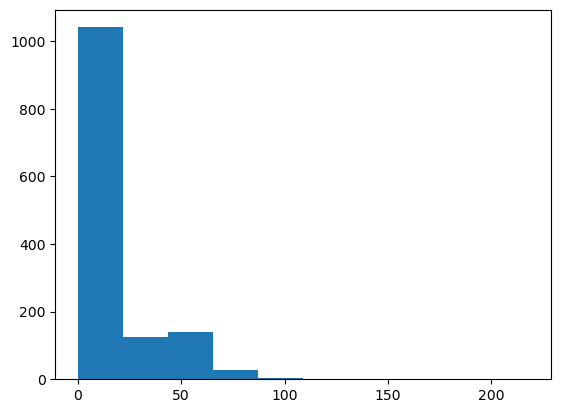

In [10]:
# check the data
plt.hist(zgdf['mean'])

In [11]:
# rename column
zgdf.rename(columns = {'mean' : col}, inplace = True)
zgdf

,geometry,pcode,obs
0,POINT (30.76360 1.17970),UGAs990142,0.0
1,POINT (6.74150 13.55660),NERs009662,6.0
2,POINT (18.05600 2.04480),COGs002937,7.0
3,POINT (39.00000 13.61640),ETHs028048,0.0
4,POINT (71.53330 34.01670),PAKs006943,49.0
...,...,...,...
1339,POINT (25.17750 4.15080),CODs006952,0.0
1340,POINT (21.95430 4.21130),CODs006973,0.0
1341,POINT (24.90420 3.98690),CODs006978,0.0
1342,POINT (22.69280 4.26910),CODs006983,0.0


In [12]:
# Save It Out
gdf_out = os.path.join(fn_out) # remove period '.' for Tmax obs
zgdf.to_file(gdf_out, index=False)

# Check Data

In [13]:
obs = gpd.read_file(os.path.join(path_in + 'wbgtmax30.avg_count_07-16.shp'))
ssp245 = gpd.read_file(os.path.join(path_in +  '2050_SSP245.wbgtmax30.avg_count_07-16.shp'))

In [14]:
obs.head(1)

,pcode,obs,geometry
0,UGAs990142,0.0,POINT (30.76360 1.17970)


In [15]:
ssp245.head(1)

,pcode,2050SSP245,geometry
0,UGAs990142,0.0,POINT (30.76360 1.17970)


In [16]:
obs[obs['obs'].isna()]

,pcode,obs,geometry
725,BGDs032275,NaN,POINT (91.37580 22.37020)
943,GNBs001123,NaN,POINT (-15.54180 11.88380)


In [17]:
ssp245[ssp245['2050SSP245'].isna()]

,pcode,2050SSP245,geometry
725,BGDs032275,NaN,POINT (91.37580 22.37020)
943,GNBs001123,NaN,POINT (-15.54180 11.88380)


# Plot

In [18]:
# Open files 
countries = gpd.read_file('./ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
obs = gpd.read_file(os.path.join(path_in + 'wbgtmax30.avg_count_07-16.shp'))
ssp245 = gpd.read_file(os.path.join(path_in +  '2050_SSP245.wbgtmax30.avg_count_07-16.shp'))

In [19]:
# Open refugee locs
gdf_fn = os.path.join('./wrl_prp_p_unhcr_refugees_noLBN_onlySettlements-2024_02.geojson')
gdf = gpd.read_file(gdf_fn)
gdf.head(1)

,iso3,pcode,gis_name,name_alt,adm1_pcode,adm2_pcode,loc_type,loc_subtype,pop_type,hierarchy_pcode,footnote,source,lon,lat,geometry
0,UGA,UGAs990142,Kyangwali,NaN,24UGA004,24UGA004118,POC,Planned Settlement,Refugee,24UGA004118021,NaN,UNHCR,30.7636,1.1797,POINT (30.76360 1.17970)


In [20]:
# drop antarctica
countries = countries[countries['CONTINENT'] != 'Antarctica']

In [21]:
# Define the custom colormap 
colors = [(1, 1, 0.7), (1, 0.65, 0), (1, 0, 0)] # Light yellow, orange, red
custom_hot = mcolors.LinearSegmentedColormap.from_list('custom_hot', colors, N=256)

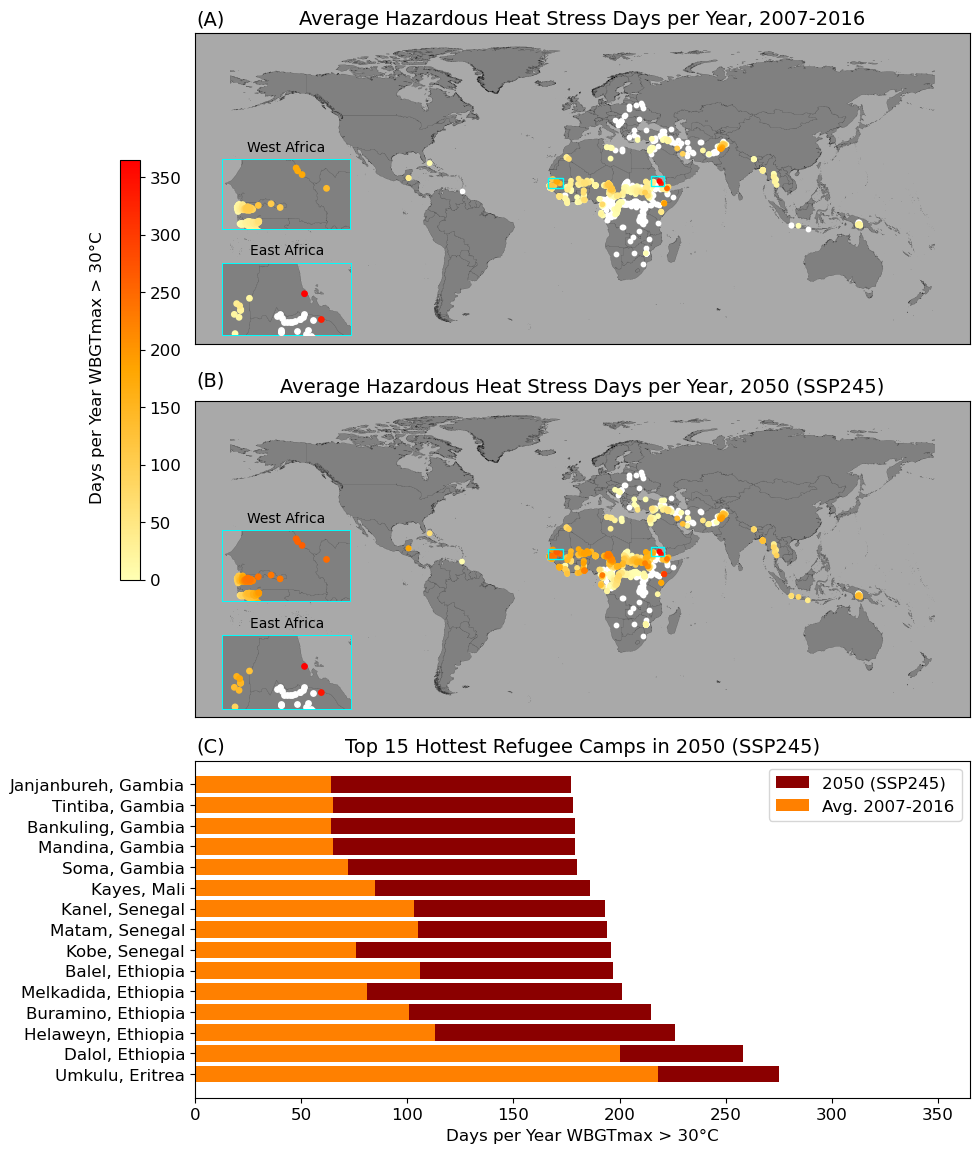

In [27]:
# Set up
rcParams['mathtext.default'] = 'regular'  # Set text to regular, not italic 
plt.rcParams['font.size'] = 12
hs = 0.01
fig, axs = plt.subplots(3, 1, figsize=(10, 14), sharex=False)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=.1)

# Obs Map Plot 
countries.plot(ax=axs[0], edgecolor='black', linewidth=0.07, facecolor='grey')
data = obs.sort_values('obs')
data = data[data['obs'] <= 0]
data.plot(ax=axs[0], color='white', markersize=10)
data = obs.sort_values('obs')
data = data[data['obs'] > 0]
data.plot(ax=axs[0], column='obs', cmap=custom_hot, vmin=0, vmax=365, norm='linear', markersize=10)
axs[0].set_facecolor('darkgrey')

# Create insets for both maps with matching aspect ratios
aspect_ratio = 1.2  # Adjust this to match your desired aspect ratio

# Inset for West Africa (same aspect ratio)
inset_ax1 = inset_axes(axs[0], width="140%", height="90%", loc='lower left', 
                       bbox_to_anchor=(-0.1, 0.26, 0.25, 0.25), bbox_transform=axs[0].transAxes, borderpad=2)
countries.plot(ax=inset_ax1, edgecolor='black', linewidth=0.07, facecolor='grey', zorder = 1)

# obs data
data = obs.sort_values('obs')
data = data[data['obs'] <= 0]
data.plot(ax=inset_ax1, markersize=15, color = 'white', zorder = 2)
data = obs.sort_values('obs')
data = data[data['obs'] > 0]
data.plot(ax=inset_ax1, column='obs', cmap=custom_hot, markersize=15, zorder = 3)
inset_ax1.set_xlim(-17.7, -10)
inset_ax1.set_ylim(12, 12 + (17 - 12) / aspect_ratio)  # Adjust ylim based on aspect ratio
inset_ax1.set_xticks([])
inset_ax1.set_yticks([])
inset_ax1.set_title('West Africa', fontsize=10)
inset_ax1.patch.set_facecolor('darkgrey')  # Remove face color
inset_ax1.patch.set_alpha(0)  # Ensure transparency
for spine in inset_ax1.spines.values():
    spine.set_edgecolor('cyan')
    spine.set_linewidth(0.7)

# Inset for East Africa (same aspect ratio)
inset_ax2 = inset_axes(axs[0], width="143%", height="93%", loc='lower left', 
                       bbox_to_anchor=(-0.103, -0.08, 0.25, 0.25), bbox_transform=axs[0].transAxes, borderpad=2)
countries.plot(ax=inset_ax2, edgecolor='black', linewidth=0.07, facecolor='grey', zorder = 1)
#show(rst, ax=inset_ax2, cmap=custom_hot, vmin=0, vmax=365, norm='linear', transform=rst.transform, zorder = 3)
#countries.plot(ax=inset_ax2, edgecolor='black', linewidth=0.07, facecolor='none', zorder =3)
data = obs.sort_values('obs')
data = data[data['obs'] <= 0]
data.plot(ax=inset_ax2, markersize=15, color = 'white', zorder = 3)
data = obs.sort_values('obs')
data = data[data['obs'] > 0]
data.plot(ax=inset_ax2, markersize=15, column='obs', cmap=custom_hot, zorder = 4)
inset_ax2.set_xlim(35, 41.9)
inset_ax2.set_ylim(13.4, 13.4 + (18 - 13.4) / aspect_ratio)  # Adjust ylim based on aspect ratio
inset_ax2.set_xticks([])
inset_ax2.set_yticks([])
inset_ax2.set_title('East Africa', fontsize=10)
inset_ax2.patch.set_facecolor('darkgrey')  # Remove face color
inset_ax2.patch.set_alpha(0)  # Ensure transparency
for spine in inset_ax2.spines.values():
    spine.set_edgecolor('cyan')
    spine.set_linewidth(0.7)

# SSP 245 Map Plot
countries.plot(ax=axs[1], edgecolor='black', linewidth=0.07, facecolor='grey')
data = ssp245.sort_values('2050SSP245')
data = data[data['2050SSP245'] <= 0]
data.plot(ax=axs[1], color = 'white', markersize=10)
data = ssp245.sort_values('2050SSP245')
data = data[data['2050SSP245'] > 0]
data.plot(ax=axs[1], column='2050SSP245', cmap=custom_hot, vmin=0, vmax=365, norm='linear', markersize=10)
axs[1].set_facecolor('darkgrey')

# Create insets for both maps with matching aspect ratios
aspect_ratio = 1.2  # Adjust this to match your desired aspect ratio

# Inset for West Africa (same aspect ratio)
inset_ax3 = inset_axes(axs[1], width="140%", height="90%", loc='lower left', 
                       bbox_to_anchor=(-0.1, 0.26, 0.25, 0.25), bbox_transform=axs[1].transAxes, borderpad=2)
countries.plot(ax=inset_ax3, edgecolor='black', linewidth=0.07, facecolor='grey', zorder = 1)
#fn_in = os.path.join('../data/processed/CHC-CMIP6/CASA/interim/obs.wbgtmax30.avg_count_07-16_zeros.tif')
#rst = rasterio.open(fn_in)  # Open raster
#show(rst, ax=inset_ax1, cmap=custom_hot, vmin=0, vmax=365, norm='linear', transform=rst.transform, zorder = 3)
#countries.plot(ax=inset_ax1, edgecolor='black', linewidth=0.07, facecolor='none', zorder =3)
data = ssp245.sort_values('2050SSP245')
data = data[data['2050SSP245'] <= 0]
data.plot(ax=inset_ax3, markersize=15, color = 'white', zorder = 2)
data = ssp245.sort_values('2050SSP245')
data = data[data['2050SSP245'] > 0]
data.plot(ax=inset_ax3, column='2050SSP245', cmap=custom_hot, markersize=15, zorder = 3)
inset_ax3.set_xlim(-17.7, -10)
inset_ax3.set_ylim(12, 12 + (17 - 12) / aspect_ratio)  # Adjust ylim based on aspect ratio
inset_ax3.set_xticks([])
inset_ax3.set_yticks([])
inset_ax3.set_title('West Africa', fontsize=10)
inset_ax3.patch.set_facecolor('darkgrey')  # Remove face color
inset_ax3.patch.set_alpha(0)  # Ensure transparency
for spine in inset_ax3.spines.values():
    spine.set_edgecolor('cyan')
    spine.set_linewidth(0.7)

# Inset for East Africa (same aspect ratio)
inset_ax4 = inset_axes(axs[1], width="143%", height="93%", loc='lower left', 
                       bbox_to_anchor=(-0.103, -0.08, 0.25, 0.25), bbox_transform=axs[1].transAxes, borderpad=2)
countries.plot(ax=inset_ax4 , edgecolor='black', linewidth=0.07, facecolor='grey', zorder = 1)
#show(rst, ax=inset_ax2, cmap=custom_hot, vmin=0, vmax=365, norm='linear', transform=rst.transform, zorder = 3)
#countries.plot(ax=inset_ax2, edgecolor='black', linewidth=0.07, facecolor='none', zorder =3)
data = ssp245.sort_values('2050SSP245')
data = data[data['2050SSP245'] <= 0]
data.plot(ax=inset_ax4, markersize=15, color = 'white', zorder = 2)
data = ssp245.sort_values('2050SSP245')
data = data[data['2050SSP245'] > 0]
data.plot(ax=inset_ax4, markersize=15, column='2050SSP245', cmap=custom_hot, zorder = 4)
inset_ax4.set_xlim(35, 41.9)
inset_ax4.set_ylim(13.4, 13.4 + (18 - 13.4) / aspect_ratio)  # Adjust ylim based on aspect ratio
inset_ax4.set_xticks([])
inset_ax4.set_yticks([])
inset_ax4.set_title('East Africa', fontsize=10)
inset_ax4.patch.set_facecolor('darkgrey')  # Remove face color
inset_ax4.patch.set_alpha(0)  # Ensure transparency
for spine in inset_ax4.spines.values():
    spine.set_edgecolor('cyan')
    spine.set_linewidth(0.7)

# Turn the grid border off
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])

# Top 15 SSP 245 
data = ssp245.sort_values('2050SSP245', ascending=False).iloc[:15, :]
data = pd.merge(data, gdf[['gis_name', 'pcode']], on='pcode', how='left')
data['country'] = ['Eritrea', 'Ethiopia', 'Ethiopia', 'Ethiopia', 'Ethiopia', 'Ethiopia', 'Senegal', 'Senegal',
                   'Senegal', 'Mali', 'Gambia', 'Gambia', 'Gambia', 'Gambia', 'Gambia']
data['label'] = data['gis_name'] + ', ' + data['country']
data = pd.merge(data, obs[['pcode', 'obs']], on='pcode', how='left')

# Bar chart
axs[2].barh(y=data['label'], width=data['2050SSP245'], color='darkred')
axs[2].barh(y=data['label'], width=data['obs'], color='#ff8000')
axs[2].set_xlim([0, 365])
axs[2].legend(labels=['2050 (SSP245)', 'Avg. 2007-2016'])
axs[2].set_xlabel('Days per Year WBGTmax > 30°C')

# Color bar
norm = mcolors.Normalize(vmin=0, vmax=365)
cb_ax = fig.add_axes([.05, 0.48, 0.02, 0.3])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_hot), orientation='vertical', cax=cb_ax)
cb_ax.text(-1.5, 69, 'Days per Year WBGTmax > 30°C', rotation=90)

# Titles
axs[0].set_title('Average Hazardous Heat Stress Days per Year, 2007-2016', fontsize=14)
axs[1].set_title('Average Hazardous Heat Stress Days per Year, 2050 (SSP245)', fontsize=14)
axs[2].set_title('Top 15 Hottest Refugee Camps in 2050 (SSP245)', fontsize=14)

# Labels
axs[0].text(-197, 95, '(A)', fontsize=14)
axs[0].text(-197, -88, '(B)', fontsize=14)
axs[1].text(-197, -84, '(C)', fontsize=14)

# Highlight West and East Africa
# Add a bounding box for the West Africa inset on the main map in Panel A (axs[0])
bbox_west_africa = patches.Rectangle(
    (-17.7, 12),  # Bottom-left corner (xmin, ymin)
    7.7, 5,  # Width and height (difference between xlim and ylim)
    linewidth=1, edgecolor='cyan', facecolor='none', zorder=4
)
axs[0].add_patch(bbox_west_africa)

# Add a bounding box for the East Africa inset on the main map in Panel A (axs[0])
bbox_east_africa = patches.Rectangle(
    (35, 13.4),  # Bottom-left corner (xmin, ymin)
    6.9, 4.6,  # Width and height (difference between xlim and ylim)
    linewidth=1, edgecolor='cyan', facecolor='none', zorder=4
)
axs[0].add_patch(bbox_east_africa)

# Similarly, add bounding boxes for the corresponding areas on the map in Panel B (axs[1])
bbox_west_africa_b = patches.Rectangle(
    (-17.7, 12),  # Bottom-left corner (xmin, ymin)
    7.7, 5,  # Width and height
    linewidth=1, edgecolor='cyan', facecolor='none', zorder=4
)
axs[1].add_patch(bbox_west_africa_b)

bbox_east_africa_b = patches.Rectangle(
    (35, 13.4),  # Bottom-left corner (xmin, ymin)
    6.9, 4.6,  # Width and height
    linewidth=1, edgecolor='cyan', facecolor='none', zorder=4
)
axs[1].add_patch(bbox_east_africa_b)

# Save the figure
fn_out = os.path.join('./wbgt30_refugees_final.png')
plt.savefig(fn_out, dpi=300, bbox_inches='tight')

plt.show()